<a href="https://colab.research.google.com/github/roaawal/sentiment-analysis-task/blob/main/sentiment_analysis%202.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
omkarsabnis_yelp_reviews_dataset_path = kagglehub.dataset_download('omkarsabnis/yelp-reviews-dataset')

print('Data source import complete.')


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/yelp-reviews-dataset/yelp.csv


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Dropout, GlobalAveragePooling1D, Conv1D, MaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

2025-04-13 13:08:50.202412: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744549730.412893      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744549730.474766      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
yelp_df = pd.read_csv("/kaggle/input/yelp-reviews-dataset/yelp.csv")

In [ ]:
yelp_df = pd.read_csv("/kaggle/input/yelp-reviews-dataset/yelp.csv")

yelp_df['sentiment'] = yelp_df['stars'].apply(lambda x: 1 if x > 3 else 0)

# Remove any rows with empty text
yelp_df = yelp_df[yelp_df['text'].notna() & (yelp_df['text'].str.strip() != '')]

# Split the data with stratification
X = yelp_df['text'].values
y = yelp_df['sentiment'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Further split training data to create a proper validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=42, stratify=y_train)

print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Test set size: {len(X_test)}")

Training set size: 6800
Validation set size: 1200
Test set size: 2000


In [ ]:
# Tokenization with limited vocabulary
max_words = 5000  # Reduced vocabulary size
max_length = 100

tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)  # Only fit on training data

# Convert text to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post', truncating='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=max_length, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding='post', truncating='post')

# Build an improved model with stronger regularization
improved_model = Sequential([
    # Embedding layer with L2 regularization
    Embedding(max_words, 50, input_length=max_length,
              embeddings_regularizer=l2(0.001)),

    # Spatial dropout to reduce overfitting in embeddings
    Dropout(0.3),

    # Convolutional layer with L2 regularization
    Conv1D(32, 3, activation='relu', kernel_regularizer=l2(0.001)),
    MaxPooling1D(2),

    # Another convolutional layer
    Conv1D(16, 3, activation='relu', kernel_regularizer=l2(0.001)),

    # Global pooling to reduce parameters
    GlobalAveragePooling1D(),

    # Dense layer with strong regularization
    Dense(16, activation='relu',
          kernel_regularizer=l2(0.01),
          bias_regularizer=l2(0.01)),
    Dropout(0.5),

    # Output layer
    Dense(1, activation='sigmoid')
])

# Compile with a lower learning rate
improved_model.compile(
    optimizer=Adam(learning_rate=0.0005),  # Lower learning rate
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Print model summary
improved_model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
I0000 00:00:1744549994.496222      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1744549994.496901      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ ?                           │     0 (unbuilt) │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Callbacks with stricter early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=2,  # Stop earlier
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=1,  # Reduce LR more aggressively
    min_lr=0.00001,
    verbose=1
)

# Train with explicit validation data instead of validation_split
improved_history = improved_model.fit(
    X_train_pad, y_train,
    epochs=15,
    batch_size=32,  # Smaller batch size
    validation_data=(X_val_pad, y_val),  # Use explicit validation set
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/15


I0000 00:00:1744550006.974284     106 service.cc:148] XLA service 0x7eed0000b5d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744550006.974948     106 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1744550006.974968     106 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1744550007.433645     106 cuda_dnn.cc:529] Loaded cuDNN version 90300


 90/213 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6027 - loss: 0.9996

I0000 00:00:1744550010.655156     106 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


213/213 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.6447 - loss: 0.9168 - val_accuracy: 0.6858 - val_loss: 0.7106 - learning_rate: 5.0000e-04
Epoch 2/15
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6890 - loss: 0.7056 - val_accuracy: 0.6858 - val_loss: 0.6594 - learning_rate: 5.0000e-04
Epoch 3/15
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6925 - loss: 0.6556 - val_accuracy: 0.6858 - val_loss: 0.6350 - learning_rate: 5.0000e-04
Epoch 4/15
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6907 - loss: 0.6399 - val_accuracy: 0.6858 - val_loss: 0.6238 - learning_rate: 5.0000e-04
Epoch 5/15
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6855 - loss: 0.6315 - val_accuracy: 0.6858 - val_loss: 0.6144 - learning_rate: 5.0000e-04
Epoch 6/15
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6830 - loss: 0.6145 - val_accuracy: 0.6858 - val_loss: 0.6008 - learning_rate: 5.0000e-04
Epoch 7/15
202/213 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6961 - 

In [ ]:
# Evaluate on test set
test_loss, test_acc = improved_model.evaluate(X_test_pad, y_test)
print(f"\nImproved Model - Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

# Get predictions
test_preds = (improved_model.predict(X_test_pad) > 0.5).astype(int)
test_probs = improved_model.predict(X_test_pad)

print("\nImproved Model Results:")
print(classification_report(y_test, test_preds))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, test_preds))
print(f"ROC AUC Score: {roc_auc_score(y_test, test_probs):.4f}")


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7413 - loss: 0.5797

Improved Model - Test Loss: 0.5664, Test Accuracy: 0.7515
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

Improved Model Results:
              precision    recall  f1-score   support

           0       0.79      0.28      0.42       627
           1       0.75      0.97      0.84      1373

    accuracy                           0.75      2000
   macro avg       0.77      0.62      0.63      2000
weighted avg       0.76      0.75      0.71      2000


Confusion Matrix:
[[ 177  450]
 [  47 1326]]
ROC AUC Score: 0.8107


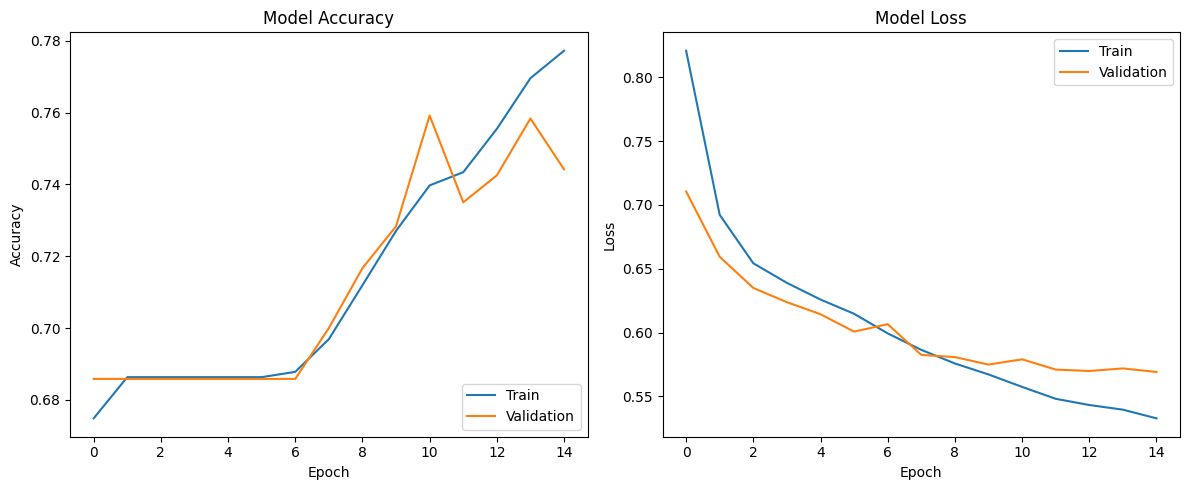

In [ ]:
# Visualize training history
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(improved_history.history['accuracy'])
plt.plot(improved_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(improved_history.history['loss'])
plt.plot(improved_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.tight_layout()
plt.savefig('improved_model_training.png')
plt.show()